In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
recent = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
recent

'2017-08-23'

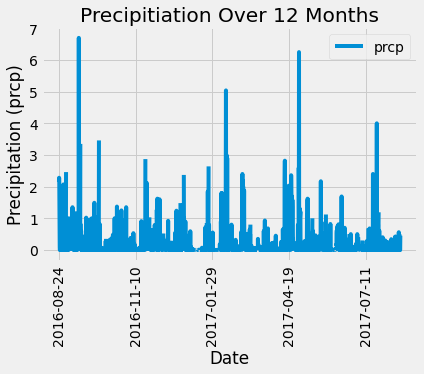

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year = dt.datetime.strptime(str(recent), "%Y-%m-%d") - dt.timedelta(days = 365)

# Perform a query to retrieve the data and precipitation scores
prcp_query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > one_year).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_query, columns = ['date', 'prcp'])
prcp_df.set_index('date', inplace = True)

# Sort the dataframe by date
prcp_df = prcp_df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot.line()
plt.xlabel('Date')
plt.ylabel('Precipitation (prcp)')
plt.xticks(rotation=90)
plt.title('Precipitiation Over 12 Months')
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number stations in the dataset
session.query(func.count(Station.id)).all()

[(9)]

In [15]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
counts = session.query(Measurement.station, func.count(Measurement.station))\
            .group_by(Measurement.station)\
            .order_by(func.count(Measurement.station).desc())
counts.all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
min_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
max_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()

print(f'Min Temp:{min_temp}, Max Temp: {max_temp}, Avg Temp: {avg_temp}')

Min Temp:[(54.0,)], Max Temp: [(85.0,)], Avg Temp: [(71.66378066378067,)]


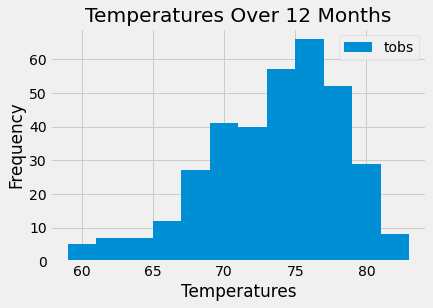

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_query = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date > one_year)\
                .filter(Measurement.station == 'USC00519281').all()

# Convert query into dataframe
temp_df = pd.DataFrame(temp_query, columns = ['date', 'tobs'])
temp_df.set_index('date', inplace = True)
temp_df = temp_df.sort_index()

# Plot
temp_df.plot.hist(bins=12)
plt.title('Temperatures Over 12 Months')
plt.xlabel('Temperatures')
plt.show()

# Close session

In [18]:
# Close Session
session.close()